In [54]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
from src.utils import *
from src.mi_estimators import *
from torch.utils.tensorboard import SummaryWriter

In [55]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
torch.set_default_tensor_type(FloatTensor)

In [56]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--d", type=int, default=20, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--gamma", type=float, default=1e-10, help="clipping parameter")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--batch_size", type=int, default=40, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-3, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--alpha", type=float, default=0, help="smooth parameter")
parser.add_argument("--reg", type=int, default=1, help="if apply regularization")
parser.add_argument("--n_epoch", type=int, default=6000, help="number of epochs of training")
parser.add_argument("--n_iters_1epoch", type=int, default=10, help="number of epochs of training")

opt, unknown = parser.parse_known_args()
opt.n_iters = opt.n_epoch * opt.n_iters_1epoch
ma_rate = 0.01  # moving average rate

In [57]:
continue_train = True  # set to True to continue to train
load_available = False # set to False to prevent loading previous results
overwrite = False  # set to True to overwrite previously stored results

In [58]:
data = GaussianData(opt.sample_size, d=opt.d, rho=opt.rho)
X, Y, XY, Ground_truth = data.X, data.Y, torch.cat((data.X, data.Y), dim=1), data.mutual_information()

In [59]:
# Use n*(n-1) samples to train DT
# x_tile = X.unsqueeze(0).repeat((opt.sample_size, 1, 1))
# y_tile = Y.unsqueeze(1).repeat((1, opt.sample_size, 1))
# train_data = torch.cat([x_tile, y_tile], dim = -1).reshape(-1, opt.d*2)
# train_label = torch.eye(x_data.shape[0]).reshape(-1,1)

# choose n marginal samples to train DT
ref_X, ref_Y = shuffle_data(X, Y, opt.sample_size)
ref_XY = torch.cat([ref_X, ref_Y], dim = 1)
train_data = torch.cat([XY, ref_XY], dim = 0)
train_label = torch.cat([torch.ones([opt.sample_size,1]), torch.zeros([opt.sample_size, 1])], dim=0)

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=20)
# clf = DecisionTreeClassifier(min_samples_leaf=400, max_depth=10)
# clf = RandomForestClassifier(n_estimators=10, min_samples_split=5)
clf.fit(train_data.cpu().numpy(),  train_label.cpu().numpy())

DecisionTreeClassifier(max_depth=20, min_samples_leaf=20)

In [61]:
path = clf.cost_complexity_pruning_path(train_data.cpu().numpy(), train_label.cpu().numpy())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp = ccp_alphas[round(len(ccp_alphas)/2)]

# clf = DecisionTreeClassifier(min_samples_leaf=5, max_depth=8)
clf = DecisionTreeClassifier(min_samples_leaf=20, max_depth=20, ccp_alpha=ccp)
# clf = RandomForestClassifier(n_estimators=10, min_samples_split=5)
clf.fit(train_data.cpu().numpy(),  train_label.cpu().numpy())

DecisionTreeClassifier(ccp_alpha=0.002742892976588626, max_depth=20,
                       min_samples_leaf=20)

In [62]:
clf.score(train_data.cpu().numpy(),  train_label.cpu().numpy())

0.77625

In [63]:
# construct the data needs to train and predict the label
x_tile = X.unsqueeze(0).repeat((opt.sample_size, 1, 1))
y_tile = Y.unsqueeze(1).repeat((1, opt.sample_size, 1))
data_matrix = torch.cat([x_tile, y_tile], dim = -1)
DT_prob_matrix = torch.Tensor(clf.predict_proba(data_matrix.reshape(-1, opt.d*2).cpu().numpy())[:,1].reshape(opt.sample_size, opt.sample_size))

In [64]:
name = f'./results/Smoothed_InfoNCE_dim{opt.d}_reg{opt.reg}_alpha{opt.alpha}'   # filename
chkpt_name = name+'.pt'      # checkpoint

from datetime import datetime
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())
writer = SummaryWriter(f'./results/log/Merge_dim{opt.d}_alpha{opt.alpha}/{TIMESTAMP}')
model = Prob_Net(opt.d*2, hidden_size=opt.hidden_dim, sigma=0.02)
# model = Prob_Net(opt.d+opt.d, hidden_size=opt.hidden_dim)
ce_loss = torch.nn.BCELoss()
mi_est_values = []
if cuda:
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), opt.lr)

In [65]:
# load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    mi_list = checkpoint['mi_list']
    model_state = checkpoint['model_state']
    model.load_state_dict(model_state)
    print('Previous results loaded.')
else:
    mi_list = [] # storing the mi estimation of each iteration

In [66]:
def randerange(*args, **kwargs):
    s = np.random.permutation(*args, **kwargs)
    t = np.random.permutation(*args, **kwargs)
    b = s != t
    return s[b], t[b]

In [67]:
# continue_train = False  # set to True to continue to train
if continue_train:
    _iter = 0
    for i in range(opt.n_epoch):
        idx = np.random.permutation(opt.sample_size)
        idx_X, idx_Y = randerange(opt.sample_size)
        for j in range(opt.n_iters_1epoch):
            batch_idx = idx[j::opt.n_iters_1epoch]
            batch_XY = XY[batch_idx]
            batch_X_ref = X[idx_X[j::opt.n_iters_1epoch]]
            batch_Y_ref = Y[idx_Y[j::opt.n_iters_1epoch]]
            batch_XY_ref = torch.cat((batch_X_ref, batch_Y_ref), dim=1)
            train_batch_XY = torch.cat((batch_XY, batch_XY_ref), dim=0)

            prob_pos = DT_prob_matrix[idx[j::opt.n_iters_1epoch], idx[j::opt.n_iters_1epoch]]
            prob_neg = DT_prob_matrix[idx_X[j::opt.n_iters_1epoch], idx_Y[j::opt.n_iters_1epoch]]
            prob_batch = torch.cat([prob_pos, prob_neg], dim=0).reshape(-1,1)
            hard_label_ = torch.cat((torch.ones(prob_pos.shape[0]), torch.zeros(prob_neg.shape[0]))).reshape(-1,1)

            label = opt.alpha*prob_batch + hard_label_*(1-opt.alpha)

            optimizer.zero_grad()
            loss = ce_loss(model(train_batch_XY), label)
            loss.backward()

            optimizer.step()
        with torch.no_grad():
            mi_est = mi_estimate(model, XY, opt.gamma, 1)
        mi_list.append(mi_est.item())

        writer.add_scalar('mi_list', mi_est.item(), _iter)
        writer.add_scalar('loss', loss, _iter)
        _iter += 1
        if _iter%200==0:
            print("Iternation: %d, loss: %f, mi_est: %f"%(_iter, loss.item(), mi_est))
            fig = plot_fig(model, X, Y, opt.d if opt.d<6 else 6)
            writer.add_figure('heatmap', fig, _iter)
            writer.add_histogram('first layer', model.fc[0].weight.data, _iter)
            writer.add_histogram('second layer', model.fc[1].weight.data, _iter)
            writer.add_histogram('third layer', model.fc[2].weight.data, _iter)

            writer.add_histogram('first layer (grad)', model.fc[0].weight.grad.data, _iter)
            writer.add_histogram('second layer (grad)', model.fc[1].weight.grad.data, _iter)
            writer.add_histogram('third layer (grad)', model.fc[2].weight.grad.data, _iter)

writer.add_graph(model, (XY,))
writer.close()

Iternation: 200, loss: 0.004783, mi_est: 9.175564
Iternation: 400, loss: 0.001658, mi_est: 11.374552
Iternation: 600, loss: 0.006157, mi_est: 11.270491
Iternation: 800, loss: 0.002337, mi_est: 14.567225
Iternation: 1000, loss: 0.000020, mi_est: 15.445611
Iternation: 1200, loss: 0.000171, mi_est: 13.615601
Iternation: 1400, loss: 0.000062, mi_est: 11.854668
Iternation: 1600, loss: 0.000048, mi_est: 13.052669
Iternation: 1800, loss: 0.000035, mi_est: 12.888811
Iternation: 2000, loss: 0.000036, mi_est: 13.471394
Iternation: 2200, loss: 0.000054, mi_est: 13.042953
Iternation: 2400, loss: 0.001180, mi_est: 14.126234
Iternation: 2600, loss: 0.000016, mi_est: 15.019649
Iternation: 2800, loss: 0.000030, mi_est: 13.013044
Iternation: 3000, loss: 0.000016, mi_est: 13.999673
Iternation: 3200, loss: 0.000019, mi_est: 13.988809
Iternation: 3400, loss: 0.000024, mi_est: 13.187497
Iternation: 3600, loss: 0.000014, mi_est: 15.824102
Iternation: 3800, loss: 0.000005, mi_est: 18.161196
Iternation: 4000,

In [68]:
mi_ma_rate = 0.01            # rate of moving average
mi_list_smooth = mi_list.copy()

for i in range(1,len(mi_list)):
    mi_list_smooth[i] = (1-mi_ma_rate) * mi_list_smooth[i-1] + mi_ma_rate * mi_list_smooth[i]

In [69]:
import os
# overwrite = True  # set to True to overwrite previously stored results
if overwrite or not os.path.exists(chkpt_name):
    model_state = model.state_dict()
    torch.save({
        'mi_list': mi_est_values,
        'mi_smooth': mi_list_smooth,
        'model_state': model_state,
        'GT': Ground_truth
    }, chkpt_name)
    print('Current results saved.')

Current results saved.


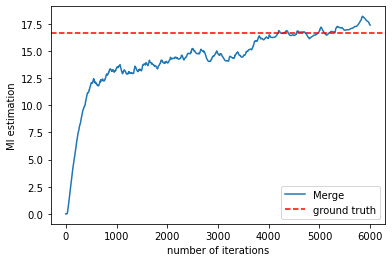

In [70]:
plt.plot(mi_list_smooth, label="Merge")

# plt.xlim((0,mi_list[0].shape[0]))
# plt.ylim((-0.5*mi,mi*5))
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
# plt.axhline(mi_list_smooth,label='MI estimate',linestyle='--',color='green')
# plt.axhline(np.log(sample_size),label='$\ln$N',linestyle='--',color='gray')
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.legend(loc='best')
# plt.savefig(f'./results/Merge_{arg.density}_samplesize{arg.sample_size}_dim{arg.d}_rho{arg.rho}.pdf')